# *Textual Analysis of Company Business Models to   Explain Varying Exposures to Covid-19 Market Shock*    

Team 8 

# Introduction
The goal of this project is to understand the impact of COVID-19 on companies' financial performance. We will undertake an analysis of company business models to explore varying exposures to COVID-19 market shock and explain how stock returns vary across U.S companies and industries from January 1 to April 3, 2020.   
Since **business description** is a brief summary of the business model, NLP Modelling (DistilBERT model) will be applied to predict YTD stock returns using companies' business descriptions. Other models (such as Naïve Bayes model) will be used to determine most predictive words for classification of 1 vs 0 labels.    

In this project, we will use 3 datasets: 
* **BA870 Project Data 2020.xlsx** - include stock returns information of a large set of U.S. companies that are affected by the COVID-19 stock market shock between January 1 and April 3, 2020. 
* **business_description.csv** - the business descriptions scraped from Yahoo Finance and will be used to do textual analysis and predict stock returns
* **sic.csv** -  SIC code and its corresponding industry and division. This will be merged with `BA870 Project Data 2020` data and `predicted results` to explore cross-sectional variation in Stock Returns. 



# Agenda:   

* Scrape business description from Yahoo Finance

* Data Cleaning

* DistilBERT Model - Accuracy prediction

 * Logistic Regression
 * SVM Model

*  Naïve Bayes Model

 * Textual Analysis
 * Industry Summary

* Result Explaination

## Preprocessing Steps

### Load libraries

In [ ]:
# Install necessary Python libraries
%%capture
! pip install requests
! pip install beautifulsoup4
! pip install transformers

In [ ]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import torch
import transformers as ppb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Import the project data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving BA870 Project Data 2020.csv to BA870 Project Data 2020.csv


In [ ]:
data = pd.read_excel('BA870 Project Data 2020.xlsx')

# Scrape Business Description from Yahoo Finance

Use the ticker list from 'BA870 Project Data 2020.xlsx' to scrape business description from Yahoo Finance.   
Results are stored as `description`.

In [ ]:
# create a ticker list
ticker_list = data['tic']
description = pd.DataFrame(columns = ['ticker', 'description'])
description['ticker'] = ticker_list

### Scrape online

In [ ]:
for tic in ticker_list:
  try:
    URL = 'https://finance.yahoo.com/quote/'+tic+'/profile'
    page = requests.get(URL)
    htmldata = BeautifulSoup(page.content,'html.parser') 
    Business_Description = htmldata.find('p',{'class':'Mt(15px) Lh(1.6)'}).text.strip()
    description.loc[description['ticker'] == tic,'description'] = Business_Description
  except AttributeError:
    pass
  continue

### Data Cleaning

Check if there's any missing business description.

In [ ]:
description.isna().sum()

In [ ]:
description[description['description'].isna()==True]

,ticker,description
84,AMPYW,NaN
159,BF.B,NaN
189,BRK.B,NaN
486,FTSV,NaN
875,NVCR,NaN
1007,RARX,NaN
1048,RTN,NaN


There are 7 companies don't have company description from scraping. The reason is that some of the tickers from WRDS don't match with Yahoo. In order to keep all companies' records, we decide to manually add back descriptions for companies with missing profiles.

In [ ]:
description.loc[description['ticker'] == "AMPYW", 'description'] = "Amplify Energy Corp. is an independent oil and natural gas company, which engages in acquisition, development, exploration and production of oil and natural gas properties. It focuses on operations in the Rockies, offshore California, Oklahoma, East Texas & North Louisiana and South Texas. The company was founded in May 2017 and is headquartered in Houston, TX."
description.loc[description['ticker'] == "BF.B", 'description'] = "Brown-Forman Corporation manufactures, bottles, imports, exports, markets, and sells various alcoholic beverages worldwide. It provides spirits, wines, whiskey spirits, whiskey-based flavored liqueurs, ready-to-drink and ready-to-pour products, ready-to-drink cocktails, vodkas, tequilas, champagnes, brandy, bourbons, and liqueurs. The company offers its products primarily under the Jack Daniel's, Woodford Reserve, Canadian Mist, GlenDronach, BenRiach, Glenglassaugh, Old Forester, Early Times, Slane Irish Whiskey, Coopers' Craft, Early Times, el Jimador, Herradura, New Mix, Pepe Lopez, Antiguo, Finlandia, Korbel Champagne, and Sonoma-Cutrer brands. It is also involved in the sale of used barrels, bulk whiskey, and wine; and provision of contract bottling services. The company serves retail customers and consumers through distributors or state governments; and retailers, wholesalers, and provincial governments directly. Brown-Forman Corporation was founded in 1870 and is headquartered in Louisville, Kentucky."
description.loc[description['ticker'] == "BRK.B", 'description'] = "Berkshire Hathaway Inc., through its subsidiaries, engages in insurance, freight rail transportation, and utility businesses. It provides property, casualty, life, accident, and health insurance and reinsurance; and operates railroad systems in North America. The company also generates, transmits, stores, and distributes electricity from natural gas, coal, wind, solar, hydro, nuclear, and geothermal sources; operates natural gas distribution and storage facilities, interstate pipelines, and compressor and meter stations; and holds interest in coal mining assets. In addition, it offers real estate brokerage services; and leases transportation equipment and furniture. Further, the company manufactures boxed chocolates and other confectionery products; specialty chemicals, metal cutting tools, and components for aerospace and power generation applications; flooring, insulation, roofing and engineered, building and engineered components, paints and coatings, and bricks and masonry products, as well as offers homebuilding and manufactured housing finance; and recreational vehicles, apparel products, jewelry, and custom picture framing products, and alkaline batteries. Additionally, it manufactures castings, forgings, fasteners/fastener systems, and aerostructures; and seamless pipes, fittings, downhole casing and tubing, and various mill forms. The company distributes newspapers, televisions, and information; franchises and services quick service restaurants; distributes electronic components; and offers logistics services, grocery and foodservice distribution services, and professional aviation training and fractional aircraft ownership programs. It also retails automobiles; furniture, bedding, and accessories; household appliances, electronics, and computers; jewelry, watches, crystal, china, stemware, flatware, gifts, and collectibles; kitchenware; and motorcycle accessories. The company was incorporated in 1998 and is headquartered in Omaha, Nebraska."
description.loc[description['ticker'] == "FTSV", 'description'] = "Forty Seven is a clinical-stage immuno-oncology company focused on developing novel checkpoint therapies to activate macrophages in the fight against cancer. Forty Seven focus its efforts on targeting the CD47 pathway as a way to engage macrophages in fighting tumors.  Macrophages function as first responders, swallowing foreign and abnormal cells, including cancer cells, and mobilizing other components of the immune system including T cells and antibodies. Cancer cells use CD47, a don’t eat me signal, to evade detection by the immune system and subsequent destruction by macrophages."
description.loc[description['ticker'] == "NVCR", 'description'] = "NovoCure Ltd. develops treatment for tumors. Its platform is called the Tumor Treating Field which used electric fields tuned to specific frequencies to disrupt solid tumor cancer cell division. The company was founded by Yoram Palti in 2000 and is headquartered in St. Helier, Jersey."
description.loc[description['ticker'] == "RARX", 'description'] = "Rafarma Pharmaceuticals, Inc. engages in the manufacture and marketing of pharmaceutical goods. It produces all types medical drugs in all delivery methods for various pharmacological groups. The company was founded on May 26, 2004 and is headquartered in Sheridan, WY."
description.loc[description['ticker'] == "RTN", 'description'] = "Raytheon Technologies Corp. engages in the provision of aerospace and defense systems and services for commercial, military, and government customers. It operates through the following segments: Collins Aerospace Systems, Pratt and Whitney, Raytheon Intelligence and Space, and Raytheon Missiles and Defense. The Collins Aerospace Systems segment specializes in the aero structures, avionics, interiors, mechanical systems, mission systems, and power controls. The Pratt and Whitney segment includes design and manufacture of aircraft engines and auxiliary power systems for commercial, military, and business aircraft. The Raytheon Intelligence and Space segment involves in the development of sensors, training, and cyber and software solutions. The Raytheon Missiles and Defense segment offers end-to-end solutions to detect, track, and engage threats. The company was founded in 2020 and is headquartered in Waltham, MA."

Check again to make sure there's no more missing description

In [ ]:
description.isna().sum()

ticker         0
description    0
dtype: int64

Save the data into a csv file (with no missing value) so that we don't need to scrap description data from yahoo finance at every run time. 

In [ ]:
description.to_csv('business_description.csv', index=False)

## Merge two dataframes

Import the newly created `businses_descrption.csv` file to a dataframe

In [ ]:
from google.colab import files
description = files.upload()

Saving business_description.csv to business_description.csv


In [ ]:
description = pd.read_csv('business_description.csv')
description.head()

,ticker,description
0,A,"Agilent Technologies, Inc. provides applicatio..."
1,AAL,"American Airlines Group Inc., through its subs..."
2,AAON,"AAON, Inc., together with its subsidiaries, en..."
3,AAP,"Advance Auto Parts, Inc. provides automotive r..."
4,AAPL,"Apple Inc. designs, manufactures, and markets ..."


Merge description and original project data and name it as **new**, The new dataset include variabls: `ticker`, `description` and `YTD Ret` only. 

In [ ]:
new = pd.merge(description, data, how='inner', left_on=['ticker'], right_on = ['tic'])
new = new[['ticker', 'description', 'YTD Ret']]
new.head()

,ticker,description,YTD Ret
0,A,"Agilent Technologies, Inc. provides applicatio...",-0.1745
1,AAL,"American Airlines Group Inc., through its subs...",-0.6726
2,AAON,"AAON, Inc., together with its subsidiaries, en...",-0.0911
3,AAP,"Advance Auto Parts, Inc. provides automotive r...",-0.4715
4,AAPL,"Apple Inc. designs, manufactures, and markets ...",-0.1779


## Descriptive Statistics

### Plot YTD Return

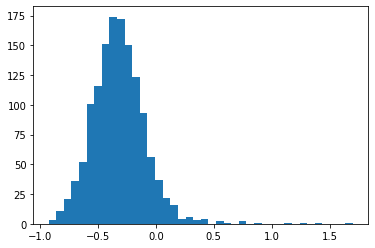

In [ ]:
plt.hist(new['YTD Ret'], bins= 40)
plt.show()

As shown by the plot, a majority of companies have YTD returns less than 0, but the spread still satisfies normal distribution with a few extreme values larger than 0.5. Thus, we decided to use **median** as a metric to assign YTD return labels. This can help avoid the influence of extreme values. 

### Creating Dummy Variable - Label

Using the Excel spreadsheet of 1,361 companies with stock returns, create a dummy variable by assigning labels to those companies. Firms whose YTD Return is above the median (50%)  has a label of `1` and conversely, firms whose YTD Return is  below the median(50%) has a label of `0`.

In [ ]:
new.loc[new['YTD Ret'] >= new['YTD Ret'].median(), 'label'] = 1
new.loc[new['YTD Ret'] < new['YTD Ret'].median(), 'label'] = 0

In [ ]:
new.describe()

,YTD Ret,label
count,1361.000000,1361.000000
mean,-0.315511,0.500367
std,0.241728,0.500184
min,-0.925700,0.000000
25%,-0.465200,0.000000
50%,-0.329500,1.000000
75%,-0.185500,1.000000
max,1.701900,1.000000


Descriptive statistics give us some first sights of the dataset. `YTD Ret` has in total of 1361 observations, most of them are negative returns. The maximum return is 1.7019 and the minimum return is -0.9257. `Label` is a dummy variable which consists of 1 and 0 only.

# DistilBERT model

## Loading the Pre-trained DistilBERT model
Let's now load a pre-trained distilBERT model. 

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Right now, the variable `model` holds a pre-trained distilBERT model.

## Preparing the Dataset
Before we can hand our sentences to BERT, we need to do some minimal processing to put them in the format it requires.

### Tokenization  

Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

In [ ]:
length = new['description'].apply(lambda x: len(x.split()))
max(length)

322

We first check the length of company description, and we find that the longest description contains 322 words. In order to save memory, we limit the tokenization length to 322.

In [ ]:
tokenized = new['description'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=322)))

### Padding  
After tokenization, `tokenized` is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Our dataset is now in the padded variable, we can view its dimensions below:

In [ ]:
padded.shape

(1361, 322)

That's what `padded` result is:

In [ ]:
padded

array([[  101, 29003,  3372, ..., 16053,  2578,   102],
       [  101,  2137,  7608, ...,     0,     0,     0],
       [  101,  9779,  2239, ...,     0,     0,     0],
       ...,
       [  101,  1062,  6038, ...,     0,     0,     0],
       [  101,  1062, 15782, ...,     0,     0,     0],
       [  101, 11199,  7315, ...,  2001,  2631,   102]])

### Masking

If we directly send `padded` to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. 

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)

# check the dimension of mask
attention_mask.shape

(1361, 322)

That's what `attention_mask` is:

In [ ]:
attention_mask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])

## Train DistilBERT Model

To predict stock YTD return label (1 or 0) for a training sample.

### Deep Learning   

Now that we have our model and inputs ready, we can run our model.

The `model()` function runs our sentences through BERT. The results of the processing will be returned into `last_hidden_states`.

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

We'll save those in the features variable, as they'll serve as the features to our logitics regression model.

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels = new['label']

### Train/Test Split
We will randomly sample 70% of data as a trainning set and 30% of data as a test set. 

In [ ]:
split = pd.DataFrame()
split['train'] = np.zeros(1361)
index = split.train.sample(frac = 0.7, random_state = 0).index.tolist()
split.at[index, 'train'] = 1

In [ ]:
train_features, test_features = features[split['train']==1], features[split['train']==0]
train_labels, test_labels = labels[split['train']==1], labels[split['train']==0]

## Logistic Regression Model

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_clf.score(test_features, test_labels)

0.7009803921568627

Running the logistic regression on the test set returns an accuracy score of **70.1%**.  

In [ ]:
test_pred = lr_clf.predict(test_features)
print(confusion_matrix(test_labels,test_pred))

[[140  59]
 [ 63 146]]


Here's the confusion matrix table:

Confusion Matrix | Positives | Negatives
--- | ---  |---
Positives |  True Positive 140 | False Positive 59  
Negatives |  False Negative 63 | True Negative 146 


As showed by both the score and the confusion matrix, the Logistic Regression Model can accurately predict most of the labels. 

## Support Vector Machine Model (SVM)

In [ ]:
from sklearn import svm

svm_clf = svm.SVC()
svm_clf.fit(train_features, train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svm_clf.score(test_features, test_labels)

0.6985294117647058

Running the SVM model on the test set returns an accuracy score of **69.85%**. 

In [ ]:
svm_pred = svm_clf.predict(test_features)
print(confusion_matrix(test_labels,svm_pred))

[[114  85]
 [ 38 171]]


Here's the confusion matrix table:

Confusion Matrix | Positives | Negatives
--- | ---  |---
Positives |  True Positive 114 | False Positive 85  
Negatives |  False Negative 38 | True Negative 171 


## Result Plots  

We decided to draw a plot based on the predicted results of logistic regression model and SVM model to compare with true labels that were pre-assigned by us.

In [ ]:
# extract the training dataset
data_test = data[split['train'] == 0]
data_test['sic'] = data_test['sic'].astype('str').apply(lambda x: x[:2])
# add the label column
data_test['label'] = new.label[split['train'] == 0]
# assign logistic and svm predicted result to the dataset name it as pred_lr and pred_svm respectively
data_test['pred_lr'] = test_pred
data_test['pred_svm'] = svm_pred
# draw random samples from a normal (Gaussian) distribution and assign it to data_test, name aas random
data_test['random'] = np.random.normal(loc=0.0, scale=1.0, size= len(data_test))

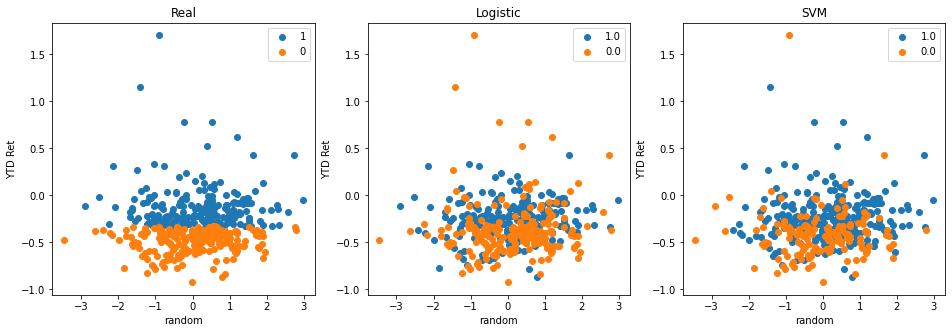

In [ ]:
# draw plots
fig = plt.figure(figsize=(16, 5))
a = fig.add_subplot(1, 3, 1)
for i in [1, 0]:
  a.scatter(x = 'random', y = 'YTD Ret', data = data_test[data_test['label'] == i], label = i)
  plt.legend(loc = 'upper right')
  plt.xlabel('random')
  plt.ylabel('YTD Ret')
  plt.title('Real')

b = fig.add_subplot(1, 3, 2)
for i in data_test['pred_lr'].unique().tolist():
  b.scatter(x = 'random', y = 'YTD Ret', data = data_test[data_test['pred_lr'] == i], label = i)
  plt.legend(loc = 'upper right')
  plt.xlabel('random')
  plt.ylabel('YTD Ret')
  plt.title('Logistic')


c = fig.add_subplot(1, 3, 3)
for i in data_test['pred_svm'].unique().tolist():
  c.scatter(x = 'random', y = 'YTD Ret', data = data_test[data_test['pred_svm'] == i], label = i)
  plt.legend(loc = 'upper right')
  plt.xlabel('random')
  plt.ylabel('YTD Ret')
  plt.title('SVM')

When drawing scatter plots, we noticed that it requires both x and y axes. Since we only have the `YTD Ret` information from the original dataset, we created a list (named as `random`) with the same length as the test dataset and have random values that satisfies normal distribution and used it as x-axis. In conclusion, both models have good performances although some are overlapping.

# Naïve Bayes estimation method

## Create Frequency Count of Words in Description

In [ ]:
import nltk
nltk.download('punkt')
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
doc = new['description'].str.lower().apply(lambda x: nltk.word_tokenize(x))

for i in new.index:
  doc[i] = [word for word in doc[i] if word not in string.punctuation]

document = [(list(doc[i]), new.label[i]) for i in new.index]

In [ ]:
# Define the feature extractor
def clean_text(text):
  text = text.lower().split()
  return text

all_words = nltk.FreqDist(new.description.apply(clean_text).explode())
word_features = list(all_words)[:2000]

def document_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

## Train a Naïve Bayes Model on Training Dataset

In [ ]:
# Train Naïve Bayes classifier
featuresets = [(document_features(d), c) for (d,c) in document]
train_set = [featuresets[i] for i in index]
test_set = [featuresets[i] for i in np.delete(np.arange(0, 1361, 1), index)]

In [ ]:
classifier = nltk.NaiveBayesClassifier.train(train_set)

## Accuracy of Naïve Bayes Model on Testing Dataset

In [ ]:
# Test the classifier
nltk.classify.accuracy(classifier, test_set)

0.6568627450980392

Using Naive Bayes model , we got the accuracy score to be **65.69%**.

## Show Most Informative Words for Classifiying Returns

In [ ]:
# Show the most important features as interpreted by Naive Bayes
classifier.show_most_informative_features(20)

Most Informative Features
  contains(destinations) = True              0.0 : 1.0    =      7.5 : 1.0
         contains(crude) = True              0.0 : 1.0    =      6.5 : 1.0
    contains(infectious) = True              1.0 : 0.0    =      6.5 : 1.0
      contains(mortgage) = True              0.0 : 1.0    =      6.1 : 1.0
         contains(drugs) = True              1.0 : 0.0    =      6.0 : 1.0
     contains(fiduciary) = True              0.0 : 1.0    =      5.7 : 1.0
      contains(dialysis) = True              1.0 : 0.0    =      5.1 : 1.0
     contains(lifecycle) = True              1.0 : 0.0    =      5.1 : 1.0
   contains(ingredients) = True              1.0 : 0.0    =      5.1 : 1.0
           contains(los) = True              0.0 : 1.0    =      4.9 : 1.0
       contains(savings) = True              0.0 : 1.0    =      4.7 : 1.0
          contains(loan) = True              0.0 : 1.0    =      4.5 : 1.0
         contains(loans) = True              0.0 : 1.0    =      4.5 : 1.0

We extracted the top 5 most informative words for both high and low returns based on pre-assigned labels.

In [ ]:
pos = ['infectious', 'drugs', 'lifecycle', 'dialysis', 'ingredients']
neg = ['destinations', 'crude', 'mortgage', 'fiduciary', 'savings']


Next, we want to go back to the industry to see if these words make sense and truely react on the impact of COVID-19 on different industries.

## Import SIC information

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sic.csv to sic.csv


In [ ]:
sic = pd.read_csv('sic.csv')
sic['sic'] = sic['sic'].astype('str')
sic.head()

,sic,industry,class,division
0,1,Agricultural Production – Crops,A,"Agriculture, Forestry, & Fishing"
1,2,Agricultural Production – Livestock,A,"Agriculture, Forestry, & Fishing"
2,7,Agricultural Services,A,"Agriculture, Forestry, & Fishing"
3,8,Forestry,A,"Agriculture, Forestry, & Fishing"
4,9,"Fishing, Hunting, & Trapping",A,"Agriculture, Forestry, & Fishing"


In [ ]:
# Add SIC data from Project Data
dm = pd.merge(new, data, how='left', left_on=['ticker','YTD Ret'], right_on = ['tic','YTD Ret'])
dm = dm[['ticker', 'description','YTD Ret', 'label','sic']]

# Only keep the first two digit of SIC
dm['sic'] = dm['sic'].astype('str').apply(lambda x: x[:2])

# Merge the dataset
dm = pd.merge(dm, sic, how = 'left', on = ['sic'])

# make description all lowercase
dm['description'] = dm['description'].apply(lambda x: x.lower())
dm.head()

,ticker,description,YTD Ret,label,sic,industry,class,division
0,A,"agilent technologies, inc. provides applicatio...",-0.1745,1.0,38,Instruments & Related Products,D,Manufacturing
1,AAL,"american airlines group inc., through its subs...",-0.6726,0.0,45,Transportation by Air,E,Transportation & Public Utilities
2,AAON,"aaon, inc., together with its subsidiaries, en...",-0.0911,1.0,35,Industrial Machinery & Equipment,D,Manufacturing
3,AAP,"advance auto parts, inc. provides automotive r...",-0.4715,0.0,55,Automative Dealers & Service Stations,G,Retail Trade
4,AAPL,"apple inc. designs, manufactures, and markets ...",-0.1779,1.0,36,Electronic & Other Electric Equipment,D,Manufacturing


## Positive and Negative Performance during COVID-19

In [ ]:
positive_result = pd.DataFrame(columns=dm.columns)
for i in pos:
  positive_result = positive_result.append(dm[dm.description.str.contains(i)]).drop_duplicates()

positive_result.head()

,ticker,description,YTD Ret,label,sic,industry,class,division
11,ABT,"abbott laboratories discovers, develops, manuf...",-0.0853,1.0,38,Instruments & Related Products,D,Manufacturing
25,ADMA,"adma biologics, inc., a biopharmaceutical and ...",-0.2275,1.0,na,NaN,NaN,NaN
28,ADPT,"adaptive biotechnologies corporation, a commer...",-0.1404,1.0,28,Chemical & Allied Products,D,Manufacturing
56,ALDX,"aldeyra therapeutics, inc., a biotechnology co...",-0.6609,0.0,28,Chemical & Allied Products,D,Manufacturing
67,ALNY,"alnylam pharmaceuticals, inc., a biopharmaceut...",-0.0812,1.0,28,Chemical & Allied Products,D,Manufacturing


In [ ]:
negative_result = pd.DataFrame(columns=dm.columns)
for i in neg:
  negative_result = negative_result.append(dm[dm.description.str.contains(i)]).drop_duplicates()

negative_result.head()

,ticker,description,YTD Ret,label,sic,industry,class,division
1,AAL,"american airlines group inc., through its subs...",-0.6726,0.0,45,Transportation by Air,E,Transportation & Public Utilities
59,ALGT,"allegiant travel company, a leisure travel com...",-0.6015,0.0,45,Transportation by Air,E,Transportation & Public Utilities
60,ALK,"alaska air group, inc., through its subsidiari...",-0.6356,0.0,45,Transportation by Air,E,Transportation & Public Utilities
223,CCL,carnival corporation & plc operates as a leisu...,-0.8330,0.0,44,Water Transportation,E,Transportation & Public Utilities
490,FWRD,"forward air corporation, together with its sub...",-0.3352,0.0,42,Trucking & Warehousing,E,Transportation & Public Utilities


# Textual Analysis

### Positive Words Result

In [ ]:
## positive words result group by label 
print("total number of companies: " + str(len(positive_result)) + "\n")
print(positive_result.groupby('label').size())

total number of companies: 94

label
0.0    19
1.0    75
dtype: int64


There are **in total of 94 companies** who have the top 5 positive words appeared in their company descriptions. Among all these companies, 75 companies behave better than the median of all companies and 19 companies behave worse than the median. 

In [ ]:
positive_result.groupby(['sic','industry','division', 'label'])['ticker'].count().sort_values(ascending = False).head(6)

sic  industry                            division         label
28   Chemical & Allied Products          Manufacturing    1.0      36
73   Business Services                   Services         1.0      10
28   Chemical & Allied Products          Manufacturing    0.0      10
38   Instruments & Related Products      Manufacturing    1.0       7
51   Wholesale Trade – Nondurable Goods  Wholesale Trade  1.0       3
20   Food & Kindred Products             Manufacturing    1.0       2
Name: ticker, dtype: int64

From the results above, we conclude that the top three divisions that got affected positively by COVID-19 are **manufacturing, services, and retail trade**.  Among the manufacturing division, industry “Chemical & Allied Products” results in the most positive returns, followed by “Instruments & Related Products”, “Food & Kindred Products”, and “Industrial Machinery & Equipment”. 
  


1. Manufacturing 
**Chemical & Allied Products**  
Due to the COVID-19 pandemic, many chemical companies are shifting production at plants around the world to meet the global demand for hand sanitizers and disinfectants. Certain active substances, such as alcohol, are in shortage as the ongoing crisis increases the demand for the products. Dozens of chemical companies have stepped in to provide supplies in the form of finished products or the substances required to make them. That’s why most chemical industries result in positive returns.  

**Instruments & Related Products**  
Manufacturers that normally make fuel-grade alcohol are switching gears to produce neutral alcohol for disinfectants. Companies in the “Instruments & Related Products” industry are responsible for the components of the medical equipment. Without those small components, we were unable to make any kind of medical equipment, not to mention sending the equipment to hospitals all around the world.  

**Food & Kindred Products**  
Due to the COVID-19 pandemic, many states provide Stay-at-Home advisory which suggests everybody stays at home and should leave their houses as less frequent as possible. People’s need for food and kindred products increased drastically due to the increment of at-home consumption and as well as the fear of the shortage of food.  

**Industrial Machinery & Equipment**  
Companies in this industry mainly produce ventilators - breathing machines used widely for COVID-19 patients. Ventilators and related medical equipment are probably the most valuable products during the pandemic.  

2. Retail Trade  
**Miscellaneous Retail**  
Retail trade refers to businesses associated with the sale of goods to the final customer. This category generally includes pharmacies, grocery stores and hypermarkets. These companies are seeing a boom as they were now designated as essential services, while other industries were not and were forced to shut down during the outbreak of COVID-19.


### Negative Words Result

In [ ]:
# negative words result group by label 
print("total number of companies: " + str(len(negative_result)) + "\n")
print(negative_result.groupby('label').size())

total number of companies: 212

label
0.0    177
1.0     35
dtype: int64


There are **in total of 212 companies** who have the top 5 negative words appeared in their company descriptions. Among all these companies, 177 companies behave worse than the median of all and 35 companies behave better than the median.

In [ ]:
negative_result.groupby(['sic','industry','division', 'label'])['ticker'].count().sort_values(ascending = False).head(6)

sic  industry                 division                           label
60   Depository Institutions  Finance, Insurance, & Real Estate  0.0      102
                                                                 1.0       18
13   Oil & Gas Extraction     Mining                             0.0       10
63   Insurance Carriers       Finance, Insurance, & Real Estate  0.0        8
73   Business Services        Services                           1.0        7
45   Transportation by Air    Transportation & Public Utilities  0.0        6
Name: ticker, dtype: int64

From the results above, we conclude that the top 3 divisions that got **affected negatively by COVID-19** are "Finance, Insurance, & Real Estate" , "Services", "Mining" and "Transportation & Public Utilities".  
  


1. Finance, Insurance & Real Estate  
**Depository Institutions**  
The outbreak of COVID-19 epidemic in the United States has been accompanied by a gradual increase in the unemployment rate. Many people have been difficult to pay for rent and mortgage loans. Therefore, the repayment of loans to banks had a negative impact. In addition, the consumption turned to daily necessities, which led to the delay and stagnation of the entire capital flow, which caused banks to be seriously hit.

**Insurance Carriers** 

Due to the outbreak of COVID-19, more people need to go to hospitals to do body examination and COVID-19 test. People use their insurances to reimburse their large medical expenses. Thus, most insurance companies result in negative returns.

2. Mining
**Oil & Gas Extraction**  
The fall in oil prices has affected the entire energy industry chain, and even energy extraction companies had a big negative impact. According to the article ”Why oil prices are crashing and what it means”, it reported that oil prices had been crushed a lot since this March 2020 due to two big reasons: Saudi price war and the oil demand influenced by COVID-19. Due to the outbreak of COVID-19, especially in China, which is the biggest importer of crude oil, the closure of factories and the cancellation of flights have greatly affected the demand for crude oil. Therefore, these reasons caused oil prices to crash.

3. Transportation & Public Utilities  
**Transportation by Air**  
With the increasing number of infected flight attendants and the increasing number of people staying at home, there are a lot of people who shift from working offline to online. In addition, changes in aviation policies have led to massive cancellations of flights all around the world. Thus, transportation by air is one of the most negatively affected industries due to the COVID-19.



## Business Services Industry


Under the Positive Words Result:
* labelled as 1, appeared 10 times

Under the Negative Words Result:
* labelled as 1, appeared 7 times

We noticed that Business Services Industry appeared in both positive and negative words results. In addition, the label of this industry is `1` even though it is being predicted in the negative words. Overall speaking, there are more `1` than `0`. Therefore, we think this industry generallt results in a positive result.  


In [ ]:
dm[dm.industry == 'Business Services'].groupby('label').ticker.count()

label
0.0     54
1.0    114
Name: ticker, dtype: int64

According to SIC code division description, business service includes establishments primarily engaged in rendering services, not elsewhere classified, to business establishments on a contract or fee basis, such as advertising, credit reporting, collection of claims, mailing, reproduction, stenographic, news syndicates, computer programming, photocopying, duplicating, data processing, services to buildings, and help supply services. COVID-19 has **more positive effects than negative influence on the business service industries** due to the special nature of business services and its various types of service. 

One industry that has been affected a lot is advertising. According to a survey provided by Influencer Marketing Hub, the brands continuing to advertise online have seen the CPMs fall and the trend in CPC flat or down, this has resulted in their return on advertising spend trending much higher than usual. Meanwhile, there has been increased interest in news with 52% increase in ad spend by news sector. Additionally, ad spend on e-commerce doubled in the U.S. from `$4.8 million` for a trailing four-week period starting on February 17 to `$9.6 million` for the week of March 9. Brands that operated both an online and physical presence have apparently moved their marketing to the web.

Another industry that has been greatly affected is computer science, as software is a growth catalyst. Study noted that Zoom, Slack, GoToMyPC, Zoho Remotely, Microsoft Office365, Atlassian, and other remote learning tools are already seeing increased demand as companies increase their remote-working capabilities. Continued growth in demand for cloud infrastructure services and potential increases in spending on specialized software, communications equipment, and telecom services for remote work and education as firms encourage workers to work from home and schools move to online courses.

In general, business service industry is performing better than the public expected and generally it is positively affected by the COVID-19.

## Validation

In [ ]:
group = dm[['ticker','label','sic']].groupby(['sic','label']).count().unstack()
group.columns = ['negative','positive']
group.sort_values(by = 'positive', ascending = False)
group.fillna(0, inplace = True)
group['total'] = group['negative'] + group['positive']

### Merge `group` and `sic` datasets

In [ ]:
gm = pd.merge(group, sic, how = 'left', on = ['sic'])
gm.sort_values(by = 'total', ascending = False)

### Performance of different divisions

In [ ]:
result = dm[['label','division']].groupby(['division']).agg(['mean','count'])
result.columns = ['mean', 'count']
result.sort_values(by = 'count', ascending = False).head(20)

,mean,count
division,,
Manufacturing,0.582397,534
"Finance, Insurance, & Real Estate",0.321168,274
Services,0.581197,234
Transportation & Public Utilities,0.596330,109
Retail Trade,0.460317,63
Mining,0.121212,33
Wholesale Trade,0.480000,25
Construction,0.300000,10
Nonclassifiable Establishments,0.750000,4


`mean` column takes the average of labels, grouped by the division. Division has mean that is larger than 0.5 means it has more positive labels (1) than negative labels (0). As showed by the above result, COVID-19 had a positive effects on divisions such as manufacturing, services, and public utilities and negative effects on divisions such as finance and mining. This mathces our textual analysis results. 

### Boxplot of YTD Return by Different Divisions

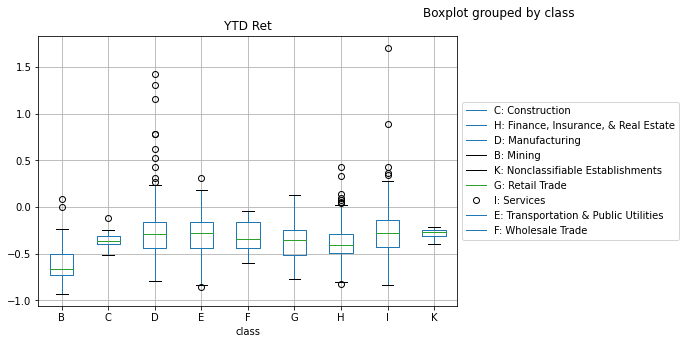

In [ ]:
legend = dm[['division', 'class', 'sic']].groupby(['division', 'class']).count().reset_index()
l_legend = []
for i in np.arange(0, 9):
  l_legend.append(legend['class'][i]  +": " + legend['division'][i])

fig = plt.figure(figsize=(16, 5))
p = fig.add_subplot(1, 2, 1)
dm.boxplot(column= 'YTD Ret', by = 'class', ax = p)
p.legend(l_legend, loc='center left', bbox_to_anchor=(1, 0.5))

# References

We utilized online resources (e.g. news, magazines, academic articles) to explore deeper about how different industries got affected by the COVID-19, either positively or negatively.

* [Why Oil Prices Are Crashing and What It Means](https://www.cnn.com/2020/03/09/business/oil-price-crash-explainer/index.html)

* [Covid-19: Mass shift to disinfectant production across the world](https://chemicalwatch.com/104936/covid-19-mass-shift-to-disinfectant-production-across-the-world#overlay-strip)

* [Coronavirus (COVID-19) Marketing & Ad Spend Impact: Report + Statistics](https://influencermarketinghub.com/coronavirus-marketing-ad-spend-report)

* [COVID-19's Impact On Tech Spending This Year](https://www.forbes.com/sites/louiscolumbus/2020/03/16/covid-19s-impact-on-tech-spending-this-year/#3e500c002d67)

* [The Odds Of A Tech Market Decline In 2020 Have Just Gone Up To 50%](https://go.forrester.com/blogs-the-odds-of-a-tech-market-decline-in-2020-have-just-gone-up-to-50/)